In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
%matplotlib inline

In [3]:
plt.style.use("fivethirtyeight")

In [4]:
def s_to_l(hand):
    try:
        hand = hand.split(",")
    except:
        pass
    
    working_hand = []
    
    for i in hand:
        try:
            working_hand.append(int(i))
        except:
            working_hand.append(i)
    return working_hand

In [5]:
def calc_ace(hand, count_A):
    # For each Ace, see if adding 11 causes it to bust
    # If no, then take Ace as 11
    # Else, take Ace as 1
    working_hand = hand.copy()
    
    # Remove Aces
    working_hand = [i if type(i) == int else 10 for i in working_hand if i != "A"]
    for k in range(count_A):
        if sum(working_hand) + 11 <= 21:
            working_hand.append(11)
        else:
            working_hand.append(1)
    return working_hand

In [6]:
def calc_points(hand):
    working_hand = s_to_l(hand)
    
    if "A" in working_hand:
        
        # Count number of Aces
        count_A = working_hand.count("A")
        working_hand = calc_ace(working_hand, count_A)
        
    else:
        # Replace J, Q, and K with 10
        working_hand = [10 if i in ["J", "Q", "K"] else int(i) for i in working_hand]
    
    return sum(working_hand)

In [7]:
def soft_17(hand):
    working_hand = s_to_l(hand)
    
    Ace_11 = False
    if calc_points(working_hand) == 17 and "A" in working_hand:
        count_A = working_hand.count("A")
        working_hand = calc_ace(working_hand, count_A)
        if 11 in working_hand[-count_A:]:
            return True
    return False

In [8]:
df = pd.read_csv("blackjack_data.csv")

In [9]:
df.head()

,d_hand,d_final_hand,p_hand,p_final_hand,strategy,split,num_decks,soft_17,d_open,d_initial,d_final,d_hit,d_bust,p_initial,p_final,p_hit,p_bust,p_win
0,"6,J","6,J,2","3,Q","3,Q",1,0,4,0,6,16,18,1,0,13,13,0,0,0
1,"7,A","7,A","Q,6","Q,6,Q",1,0,4,1,7,18,18,0,0,16,26,1,1,0
2,"10,4","10,4,K","Q,5","Q,5",0,0,4,0,10,14,24,1,1,15,15,0,0,1
3,"2,K","2,K,6","3,7","3,7,A",0,0,4,1,2,12,18,1,0,10,21,1,0,1
4,"J,7","J,7","8,6","8,6",0,0,4,0,10,17,17,0,0,14,14,0,0,0


# How often do you win?

In [10]:
def get_win_p(data, num_games=100, soft=0, strategy=0):
    games = data.copy()
    games = games[games.soft_17==soft]
    games = games[games.strategy==strategy]
    games = games.p_win
    out = np.random.choice(games, size=num_games)
    return sum(out)/num_games

In [11]:
soft_random = [get_win_p(df, soft=1) for _ in range(10000)]
ns_random = [get_win_p(df) for _ in range(10000)]
soft_rec = [get_win_p(df, soft=1, strategy=1) for _ in range(10000)]
ns_rec = [get_win_p(df, strategy=1) for _ in range(10000)]

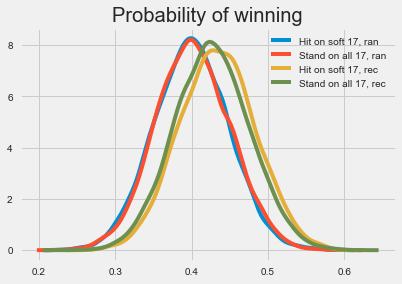

In [12]:
sns.distplot(soft_random, hist=False, label="Hit on soft 17, ran");
sns.distplot(ns_random, hist=False, label="Stand on all 17, ran");
sns.distplot(soft_rec, hist=False, label="Hit on soft 17, rec");
sns.distplot(ns_rec, hist=False, label="Stand on all 17, rec");
plt.title("Probability of winning");

In [13]:
# Looks like we're more likely to win when we're playing the recommended strategy
# Is the difference significant?
print ("Difference between random and recommended,\n dealer required to hit on soft 17:\n  {}\n".format(stats.ttest_ind(soft_random, soft_rec)))
print ("Difference between random and recommended,\n dealer stands on all 17:\n  {}\n".format(stats.ttest_ind(ns_random, ns_rec)))

Difference between random and recommended,
 dealer required to hit on soft 17:
  Ttest_indResult(statistic=-48.538902383482103, pvalue=0.0)

Difference between random and recommended,
 dealer stands on all 17:
  Ttest_indResult(statistic=-36.244399253068444, pvalue=1.1950296851577611e-278)



# How often does the dealer have to hit?

- Ignore player's hand
    - Dealer has to hit if he has below 17
    - Sometimes dealer has to hit if he has a soft 17
        - Depends on casino

In [14]:
def need_to_hit(data, num_games=100, soft=0):
    choices = [i for i in data.index]
    games = data.copy()
    games = games.ix[np.random.choice(choices, size=num_games)]
    below = sum(games.d_initial < 17)
    if soft == 1:
        all_17 = games.d_hand[games.d_initial == 17]
        for i in all_17:
            if soft_17(i):
                below += 1
    return below/num_games

## When the dealer is not required to hit on soft 17

In [15]:
non_soft17_df = df[df.soft_17==0]

In [16]:
ep_time_hit = [need_to_hit(non_soft17_df) for _ in range(10000)]

In [17]:
ep_time_hit = pd.DataFrame(ep_time_hit, columns=["hit"])

## When the dealer is required to hit on soft 17

In [18]:
soft17_df = df[df.soft_17==1]

In [19]:
ep_time_hit_soft = [need_to_hit(soft17_df, soft=1) for _ in range(10000)]

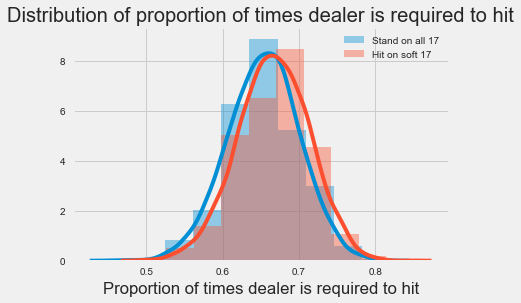

In [38]:
sns.distplot(ep_time_hit, bins=10, label="Stand on all 17");
sns.distplot(ep_time_hit_soft, bins=10, label="Hit on soft 17");
plt.title("Distribution of proportion of times dealer is required to hit");
plt.xlabel("Proportion of times dealer is required to hit");
plt.legend();

# Distribution of dealer's points

- We're interested in before and after the dealer hits

## Initial points

- How often does the dealer get dealt a hand that's 18, 19, 20 or 21?

In [21]:
def get_hand_games(data, col, point, num_games=100):
    all_points = data[col]
    games = np.random.choice(all_points, size=num_games)
    return sum(games == point)/num_games

In [22]:
dist_18 = [get_hand_games(df, "d_initial", 18) for _ in range(10000)]
dist_19 = [get_hand_games(df, "d_initial", 19) for _ in range(10000)]
dist_20 = [get_hand_games(df, "d_initial", 20) for _ in range(10000)]
dist_21 = [get_hand_games(df, "d_initial", 21) for _ in range(10000)]

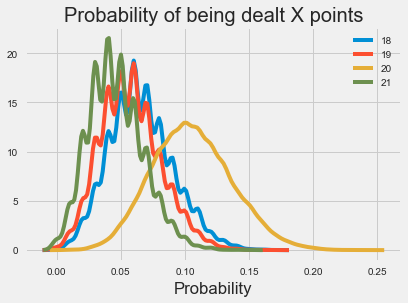

In [23]:
sns.distplot(dist_18, hist=False, label=18);
sns.distplot(dist_19, hist=False, label=19);
sns.distplot(dist_20, hist=False, label=20);
sns.distplot(dist_21, hist=False, label=21);
plt.title("Probability of being dealt X points");
plt.xlabel("Probability");

## Final points

- How often does the dealer end up with a hand that's 18, 19, 20 or 21?

In [24]:
dist_f18 = [get_hand_games(df, "d_final", 18) for _ in range(10000)]
dist_f19 = [get_hand_games(df, "d_final", 19) for _ in range(10000)]
dist_f20 = [get_hand_games(df, "d_final", 20) for _ in range(10000)]
dist_f21 = [get_hand_games(df, "d_final", 21) for _ in range(10000)]

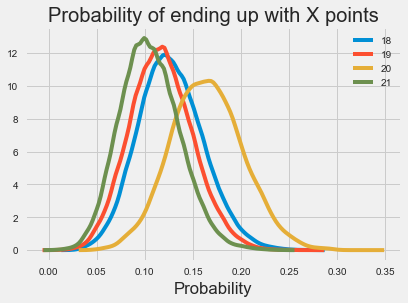

In [25]:
sns.distplot(dist_f18, hist=False, label=18);
sns.distplot(dist_f19, hist=False, label=19);
sns.distplot(dist_f20, hist=False, label=20);
sns.distplot(dist_f21, hist=False, label=21);
plt.title("Probability of ending up with X points");
plt.xlabel("Probability");

# Distribution of player's points

## Initial points

- How often does the player get dealt a hand that's 18, 19, 20 or 21?

In [26]:
distp_18 = [get_hand_games(df, "p_initial", 18) for _ in range(10000)]
distp_19 = [get_hand_games(df, "p_initial", 19) for _ in range(10000)]
distp_20 = [get_hand_games(df, "p_initial", 20) for _ in range(10000)]
distp_21 = [get_hand_games(df, "p_initial", 21) for _ in range(10000)]

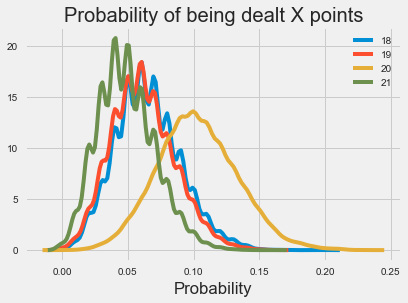

In [27]:
sns.distplot(distp_18, hist=False, label=18);
sns.distplot(distp_19, hist=False, label=19);
sns.distplot(distp_20, hist=False, label=20);
sns.distplot(distp_21, hist=False, label=21);
plt.title("Probability of being dealt X points");
plt.xlabel("Probability");

## Final points

- How often does the player end up with a hand that's 18, 19, 20 or 21?

In [28]:
distp_f18 = [get_hand_games(df, "p_final", 18) for _ in range(10000)]
distp_f19 = [get_hand_games(df, "p_final", 19) for _ in range(10000)]
distp_f20 = [get_hand_games(df, "p_final", 20) for _ in range(10000)]
distp_f21 = [get_hand_games(df, "p_final", 21) for _ in range(10000)]

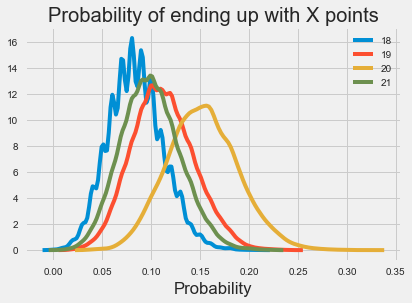

In [29]:
sns.distplot(distp_f18, hist=False, label=18);
sns.distplot(distp_f19, hist=False, label=19);
sns.distplot(distp_f20, hist=False, label=20);
sns.distplot(distp_f21, hist=False, label=21);
plt.title("Probability of ending up with X points");
plt.xlabel("Probability");

# Comparing dealer and player

## Initial points

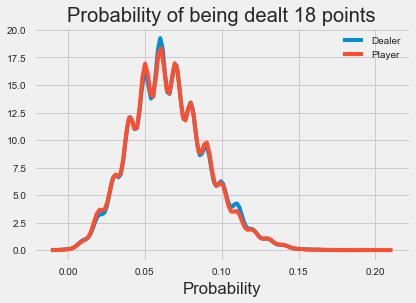

In [30]:
sns.distplot(dist_18, hist=False, label="Dealer");
sns.distplot(distp_18, hist=False, label="Player");
plt.title("Probability of being dealt {} points".format(18));
plt.xlabel("Probability");

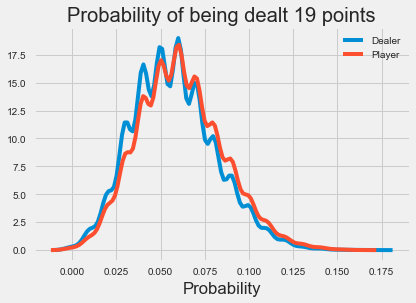

In [31]:
sns.distplot(dist_19, hist=False, label="Dealer");
sns.distplot(distp_19, hist=False, label="Player");
plt.title("Probability of being dealt {} points".format(19));
plt.xlabel("Probability");

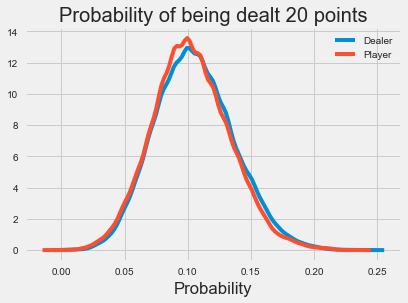

In [32]:
sns.distplot(dist_20, hist=False, label="Dealer");
sns.distplot(distp_20, hist=False, label="Player");
plt.title("Probability of being dealt {} points".format(20));
plt.xlabel("Probability");

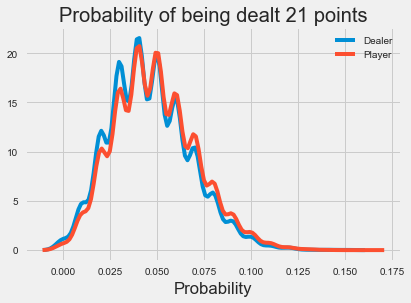

In [33]:
sns.distplot(dist_21, hist=False, label="Dealer");
sns.distplot(distp_21, hist=False, label="Player");
plt.title("Probability of being dealt {} points".format(21));
plt.xlabel("Probability");

## Final points

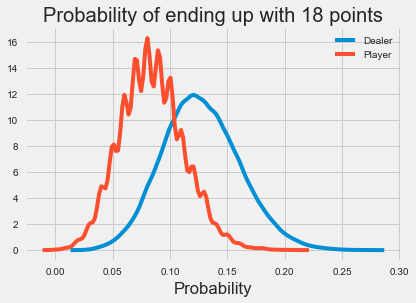

In [34]:
sns.distplot(dist_f18, hist=False, label="Dealer");
sns.distplot(distp_f18, hist=False, label="Player");
plt.title("Probability of ending up with {} points".format(18));
plt.xlabel("Probability");

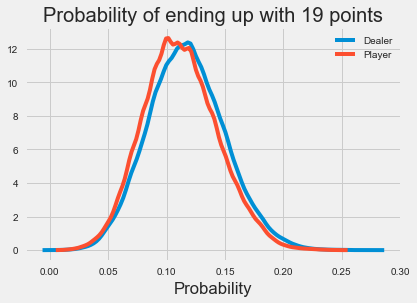

In [35]:
sns.distplot(dist_f19, hist=False, label="Dealer");
sns.distplot(distp_f19, hist=False, label="Player");
plt.title("Probability of ending up with {} points".format(19));
plt.xlabel("Probability");

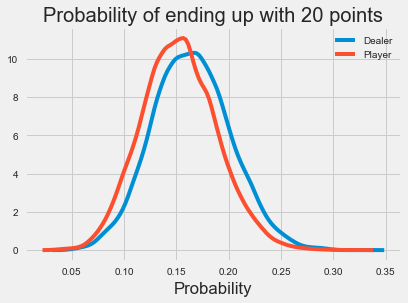

In [36]:
sns.distplot(dist_f20, hist=False, label="Dealer");
sns.distplot(distp_f20, hist=False, label="Player");
plt.title("Probability of ending up with {} points".format(20));
plt.xlabel("Probability");

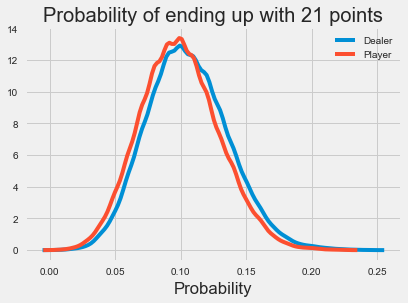

In [37]:
sns.distplot(dist_f21, hist=False, label="Dealer");
sns.distplot(distp_f21, hist=False, label="Player");
plt.title("Probability of ending up with {} points".format(21));
plt.xlabel("Probability");

# Do you do better splitting on 8s?

In [57]:
rec = df.copy()
rec = rec[rec.strategy == 1]

In [58]:
def double_8(s):
    l = s.split(",")
    new_l = []
    for i in l:
        try:
            new_l.append(int(i))
        except:
            new_l.append(i)
    if new_l[0] == 8 and new_l[1] == 8:
        out = True
    else:
        out = False
    return int(out)

In [59]:
rec["double_8"] = rec.p_hand.apply(double_8)

In [60]:
double = rec[(rec.split==1) | (rec.double_8==1)]

In [86]:
def get_d_trials(data, split=0, num_games=100):
    results = data.p_win[data.split==split]
    out = np.random.choice(results, size=num_games)
    return sum(out)/num_games

In [87]:
split_8 = [get_d_trials(rec, split=1) for _ in range(10000)]
no_split = [get_d_trials(rec, split=0) for _ in range(10000)]

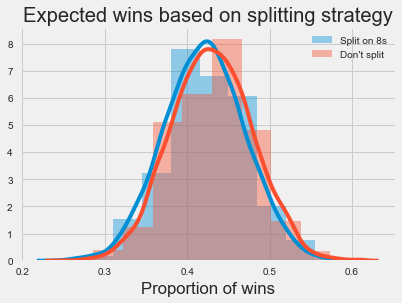

In [76]:
sns.distplot(split_8, bins=10, label="Split on 8s");
sns.distplot(no_split, bins=10, label="Don't split");
plt.xlabel("Proportion of wins");
plt.legend();
plt.title("Expected wins based on splitting strategy");

In [80]:
np.mean(split_8)

0.42113199999999995

In [81]:
np.mean(no_split)

0.42999399999999999

In [78]:
# Looks like we're no better splitting on the 8s
stats.ttest_ind(split_8, no_split)

Ttest_indResult(statistic=-12.672798811920511, pvalue=1.1577451124951427e-36)

# Do you do better splitting on any doubles?

In [82]:
def double_cards(s):
    l = s.split(",")
    new_l = []
    for i in l:
        try:
            new_l.append(int(i))
        except:
            new_l.append(i)
    if new_l[0] == new_l[1]:
        out = True
    else:
        out = False
    return int(out)

In [83]:
doubles = df.copy()
doubles["doubles"] = doubles.p_hand.apply(double_cards)

In [84]:
doubles = doubles[(doubles.split==1) | (doubles.doubles==1)]

In [88]:
split_d = [get_d_trials(doubles, split=1) for _ in range(10000)]
no_split_d = [get_d_trials(doubles, split=0) for _ in range(10000)]

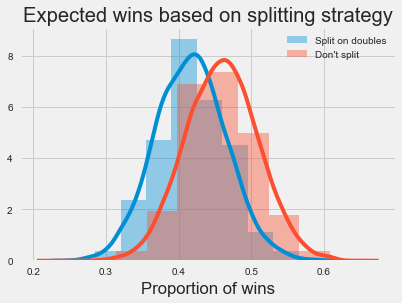

In [89]:
sns.distplot(split_d, bins=10, label="Split on doubles");
sns.distplot(no_split_d, bins=10, label="Don't split");
plt.xlabel("Proportion of wins");
plt.legend();
plt.title("Expected wins based on splitting strategy");

## Dealer points

- Safe
    - Dealer has to hit, but he will not bust with one card
- Hit
    - Dealer has to hit and there's a chance he will bust with one card
- Stand
    - Dealer does not have to hit

# Questions

## When the dealer is in the safe zone, how often does he bust?

## When the dealer is in the hit zone, how often does he bust?